# Задание **Pro**

Добейтесь точности 85% (в идеале 90%) на базе по договорам.

Подсказка: Можно использовать альтернативные варианты обработки данных, например заменив word2vec из библиотеки GENSIM на embedding слой в нейросети.

# Импорт бибилтотек

In [ ]:
!pip install -q pymorphy2

In [ ]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense, Embedding, Input, concatenate, Activation, MaxPooling1D, Conv1D, BatchNormalization, Dropout, Conv2DTranspose, Conv1DTranspose, Lambda
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, Adadelta
from tensorflow.keras.utils import plot_model

from gensim.models import word2vec # Импортируем gensim

import os
import re
import pandas as pd
import numpy as np
from time import time
import nltk 
from nltk.stem import WordNetLemmatizer  
import pymorphy2 

nltk.download('wordnet') # Скачиваем сетку слов для лемматизации

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Функции для работы с текстами

In [ ]:
# Лист тегов и их значений:

# <s1> - Условия 
# <s2> - Запреты
# <s3> - Цена
# <s4> - Условия (относительно дат)
# <s5> - Штрафы
# <s6> - Адреса и местоположения

In [ ]:
# Функция для удаления пунктуационных знаков препинания и еще дополнительных ненужных нам знаков из файла
def readText(fileName):
  f = open(fileName, 'r')
  text = f.read()
  delSymbols = ['\n', "\t", "\ufeff", ".", "_", "-", ",", "!", "?", "–", "(", ")", "«", "»", "№", ";",'•','%']

  for dS in delSymbols:
    text = text.replace(dS, " ")

  text = re.sub('[.]', ' ', text)
  text = re.sub(':', ' ', text)
  text = re.sub('<', ' <', text)
  text = re.sub('>', '> ', text)

  return ' '.join(text.split()).lower()

In [ ]:
# Функция которая конвертирует исходный текст в лист слов с начальной формой
def text2Words(text):
  morph = pymorphy2.MorphAnalyzer()
  words = text.split(" ")
  return [morph.parse(word)[0].normal_form for word in words]  

# Чтение файла

In [ ]:
directory = '/content/drive/MyDrive/УИИ/Cегментация текста/База договоров/'
os.listdir(directory)[400:410]

['Трудовой договор с медицинским работником.txt',
 'Трудовой договор с коммерческим директором ООО.txt',
 'Трудовой договор с исполнительным директором ООО.txt',
 'Трудовой договор с испытательным сроком.txt',
 'Трудовой договор с кассиром.txt',
 'Трудовой договор с педагогическим работником.txt',
 'Трудовой договор с иностранным работником (подсобный рабочий).txt',
 'Трудовой договор с продавцом.txt',
 'Трудовой договор с работником ООО на срок до 2-х месяцев (полный).txt',
 'Трудовой договор с работником ООО на срок до 2-х месяцев (краткий).txt']

In [ ]:
# Всего договоров
print(len(os.listdir(directory)), 'договора для обучения')

432 договора для обучения


In [ ]:
curTime = time()
agreements = [] # список договоров
for filename in os.listdir(directory):
  txt = readText(directory + filename)
  if txt != "":
    agreements.append(txt)
print(f'Загрузка файла заняла: {round(time() - curTime, 2)} с.')

Загрузка файла заняла: 1.5 с.


In [ ]:
# Конвертирует исходный текст
docs_full = []
currTime = time()
for i in range(len(agreements)):
   docs_full.append(text2Words(agreements[i]))

print(f'Времени потребовалось: {round(time() - curTime, 2)} с.')

Времени потребовалось: 205.35 с.


In [ ]:
# Выводим число записей в наборе данных 
print(len(docs_full))

422


## Разделение на выборки

In [ ]:
# Выбираем итоговое количество данных для обучающей/проверочной и тестовой выборках
docsToTrain = docs_full[0:-10]
docsToTest = docs_full[-10:]

In [ ]:
print('Число текстов в для тестовой проверки в конце ноутбука:', len(docsToTest)) 
print('Число договоров для обучающей и проверочной выборках:',len(docsToTrain)) 
print('Число слов в первом договоре:', len(docsToTrain[0]))

Число текстов в для тестовой проверки в конце ноутбука: 10
Число договоров для обучающей и проверочной выборках: 412
Число слов в первом договоре: 1149


# Превращение текстов в последовтельность индексов: создание xTrain

In [ ]:
tokenizer = Tokenizer(lower=True, filters='', char_level=False)
tokenizer.fit_on_texts(docs_full)
clean_voc = {} # Создаем пустой словарь

for i in tokenizer.word_index.items():
  clean_voc[i[0]] = i[1]

In [ ]:
print('Словарь всех слов по их частотноти:') 
print(clean_voc, '\n')
print('Длина словаря:', len(clean_voc))

tag = '<s2>'
print('Индекс тега', tag, ':' ,clean_voc[tag])

Словарь всех слов по их частотноти:
{'в': 1, 'договор': 2, 'и': 3, '2': 4, '1': 5, 'по': 6, 'сторона': 7, 'с': 8, 'настоящий': 9, 'на': 10, '3': 11, '<s1>': 12, '</s1>': 13, 'не': 14, '4': 15, 'или': 16, 'за': 17, 'он': 18, 'случай': 19, 'о': 20, '5': 21, '<s3>': 22, '</s3>': 23, 'право': 24, 'работа': 25, 'срок': 26, '<s4>': 27, '</s4>': 28, 'от': 29, 'при': 30, 'они': 31, '6': 32, 'другой': 33, 'быть': 34, 'лицо': 35, 'имущество': 36, 'день': 37, 'действовать': 38, 'арендатор': 39, 'условие': 40, 'для': 41, '7': 42, 'к': 43, 'если': 44, 'п': 45, 'дальнейший': 46, 'работник': 47, 'который': 48, 'а': 49, 'обязательство': 50, 'страховой': 51, 'законодательство': 52, 'порядок': 53, 'сумма': 54, 'размер': 55, 'действие': 56, 'арендодатель': 57, 'свой': 58, 'счёт': 59, 'соответствие': 60, 'указанный': 61, 'именовать': 62, 'мочь': 63, 'из': 64, 'основание': 65, 'обязанность': 66, 'обязать': 67, 'исполнение': 68, 'один': 69, 'страховщик': 70, 'страхователь': 71, 'иной': 72, 'год': 73, 'до': 

In [ ]:
# Превращает текст в последовательность индексов согласно словарю частотности
tok_agreem = tokenizer.texts_to_sequences(docsToTrain)

print("Исходный текст:              ", docsToTrain[50][:20])
print("Последовательность индексов: ", tok_agreem[50][:20])

Исходный текст:               ['договор', 'аренда', 'земельный', 'участок', 'находиться', 'в', 'государственный', 'или', 'муниципальный', 'собственность', 'г', 'г', 'в', 'лицо', 'действовать', 'на', 'основание', 'именовать', 'в', 'дальнейший']
Последовательность индексов:  [2, 116, 211, 169, 253, 1, 204, 16, 1287, 130, 76, 76, 1, 35, 38, 10, 65, 62, 1, 46]


# Создание yTrain

In [ ]:
#  Собираем лист индексов и их мультилейбл класссификации
def getXYSamples(tok_agreem, tags_index):
  tags01 = []
  indices = []

  for agreement in tok_agreem:
    tag_place = [0, 0, 0, 0, 0, 0, 0]
    for ex in agreement:
      if ex in tags_index:
        place = np.argwhere(tags_index==ex)
        if len(place) !=0:
          if place[0][0] < 6:
            tag_place[place[0][0]] = 1
          else:
            tag_place[place[0][0] - 6] = 0
        if any(tag_place):
          tag_place[6] = 1
      else:
        tags01.append(tag_place.copy())
        indices.append(ex)
  return indices, tags01

In [ ]:
# Функция получение списка слов из списка индексов
def reverseIndex(clean_voc, x):
  reverse_word_map = dict(map(reversed, clean_voc.items()))
  docs = [reverse_word_map.get(letter) for letter in x]
  return docs

In [ ]:
#<s1> - Условия договора
#<s2> - Запреты
#<s3> - Стоимость
#<s4> - Условия (относительно дат)
#<s5> - Штрафы
#<s6> - Адреса и местоположения

tags_index = ['<s' + str(i) + '>' for i in range(1, 7)] # Лист открывающих тегов
closetags = ['</s' + str(i) + '>' for i in range(1, 7)] # Лист закрывающих тегов
tags_index.extend(closetags) # конкатенируем все теги

tags_index = np.array([clean_voc[i] for i in tags_index]) # Получаем инексы всех тегов из словря частотности
print('Индексы всех тегов:', tags_index)

Индексы всех тегов: [ 12 341  22  27 117 278  13 352  23  28 118 272]


In [ ]:
# Получаем теги и создаём листы с ними
curTime = time()
xData, yData = getXYSamples(tok_agreem,tags_index)
decoded_text = reverseIndex(clean_voc, xData) # Превращаем список индексов обратно в список слов
print(f'Время: {round(time() - curTime, 2)} с.')

Время: 3.66 с.


In [ ]:
print('длина xData:', len(xData))
print('длина yData:', len(yData))
print()
print('Посмотрим на исходные слова: ', docsToTrain[0][50:70])
print('Сдекодированые слова:', decoded_text[50:70])
print()
print('Часть xData:     ', xData[50:70])
print('Часть yData:     ', yData[50:70])

длина xData: 410727
длина yData: 410727

Посмотрим на исходные слова:  ['1', 'предмет', 'договор', '1', '1', '<s1>', 'по', 'настоящий', 'договор', 'хранитель', 'обязываться', 'хранить', 'вещь', 'передать', 'он', 'поклажедатель', 'и', 'возвратить', 'этот', 'вещь']
Сдекодированые слова: ['1', 'предмет', 'договор', '1', '1', 'по', 'настоящий', 'договор', 'хранитель', 'обязываться', 'хранить', 'вещь', 'передать', 'он', 'поклажедатель', 'и', 'возвратить', 'этот', 'вещь', 'в']

Часть xData:      [5, 112, 2, 5, 5, 6, 9, 2, 224, 115, 918, 319, 125, 18, 250, 3, 546, 244, 319, 1]
Часть yData:      [[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 

# Разделение выборки на окна

In [ ]:
# Создание выборки из индексов
def getSetFromIndices(wordIndices, xLen, step):
  xBatch = []
  wordsLen = len(wordIndices)
  index = 0
  while (index + xLen <= wordsLen):
    xBatch.append(wordIndices[index:index+xLen])
    index += step
  return xBatch

In [ ]:
xLen = 256
step = 30
embeddingSize = 300 # Пространство Embedding

In [ ]:
#  Генерируем выборки с параметрами наших окон
xTrain = getSetFromIndices(decoded_text, xLen, step)
yTrain = getSetFromIndices(yData, xLen, step)

### Проверка 

In [ ]:
print('Длина xTrain:', len(xTrain))
print('Длина yTrain:', len(yTrain))
print('Длина примера из xTrain:',len(xTrain[0]))
print('Длина примера из yTrain:',len(yTrain[0]), '\n')
print('Пример xTrain', xTrain[0])
print('Пример yTrain', yTrain[0], '\n')

print('Первый пример xTrain:', xTrain[0][step-5:step+5])
print('Второй пример xTrain:', xTrain[1][:10])

Длина xTrain: 13683
Длина yTrain: 13683
Длина примера из xTrain: 256
Длина примера из yTrain: 256 

Пример xTrain ['договор', 'безвозмездный', 'хранение', 'до', 'востребование', 'г', 'г', 'гражданин', 'паспорт', 'серия', 'номер', 'выдать', 'проживать', 'по', 'адрес', 'именовать', 'в', 'дальнейший', 'хранитель', 'с', 'один', 'сторона', 'и', 'гражданин', 'паспорт', 'серия', 'номер', 'выдать', 'проживать', 'по', 'адрес', 'именовать', 'в', 'дальнейший', 'поклажедатель', 'с', 'другой', 'сторона', 'именовать', 'в', 'дальнейший', 'сторона', 'заключить', 'настоящий', 'договор', 'в', 'дальнейший', 'договор', 'о', 'нижеследующий', '1', 'предмет', 'договор', '1', '1', 'по', 'настоящий', 'договор', 'хранитель', 'обязываться', 'хранить', 'вещь', 'передать', 'он', 'поклажедатель', 'и', 'возвратить', 'этот', 'вещь', 'в', 'сохранность', '1', '2', 'поклажедатель', 'передавать', 'на', 'хранение', 'по', 'настоящий', 'договор', 'следующий', 'вещь', 'далее', 'вещь', '1', '3', 'при', 'передача', 'вещь', 'по

### Текст в последовательность индексов

In [ ]:
tok_agreemTest = tokenizer.texts_to_sequences(docsToTest)

print("Посмотрим на фрагмент тестового текста:")
print()
print("Исходный текст:                                   ", docsToTest[5][:20])
print("Тот же текст, но как последовательность индексов: ", tok_agreemTest[5][:20])

Посмотрим на фрагмент тестового текста:

Исходный текст:                                    ['трудовой', 'контракт', 'с', 'специалист', 'г', 'г', 'в', 'лицо', 'действовать', 'на', 'основание', 'именовать', 'в', 'дальнейший', 'работодатель', 'с', 'один', 'сторона', 'и', 'гражданин']
Тот же текст, но как последовательность индексов:  [79, 187, 8, 897, 76, 76, 1, 35, 38, 10, 65, 62, 1, 46, 129, 8, 69, 7, 3, 265]


In [ ]:
# Распознаём теги и создаём лист, что их хранят
xDataTest, yDataTest = getXYSamples(tok_agreemTest, tags_index)

# Превращаем из списка индекса обратно в список слов
decoded_text = reverseIndex(clean_voc, xDataTest)

print('Длина xDataTest:', len(xDataTest))
print('Длина yDataTest:', len(yDataTest))
print()
print('Сдекодированные текст:', decoded_text[200:230])
print('Часть xDataTest:     ', xDataTest[200:230])
print('Часть yDataTest:     ', yDataTest[200:230])

Длина xDataTest: 10723
Длина yDataTest: 10723

Сдекодированные текст: ['2', 'основной', 'условие', 'договор', '2', '1', 'гр', 'назначаться', 'на', 'должность', 'директор', 'на', 'основание', 'решение', 'совет', 'директор', 'протокол', 'от', 'год', 'работодатель', 'поручать', 'директор', 'решение', 'весь', 'вопрос', 'текущий', 'деятельность', 'общество', 'за', 'исключение']
Часть xDataTest:      [4, 592, 40, 2, 4, 5, 523, 1530, 10, 495, 217, 10, 65, 280, 537, 217, 872, 29, 73, 129, 1005, 217, 280, 120, 248, 403, 148, 146, 17, 415]
Часть yDataTest:      [[0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 0, 0, 1], [0, 

In [ ]:
# Генерируем выборки
xTest = getSetFromIndices(decoded_text, xLen, step)
yTest = getSetFromIndices(yDataTest, xLen, step)

print('Длина xTest:', len(xTest))
print('Длина yTest:', len(yTest))
print()

print('Длина примера xTest:',len(xTest[10]))
print('Длина примера yTrain:',len(yTest[10]), '\n')

print('Пример xTest', xTest[10])
print('Пример yTest', yTest[10], '\n')

print('Первый пример xTest:', xTest[0][step-10:step+10])
print('Второй пример xTest:', xTest[1][:15])

Длина xTest: 349
Длина yTest: 349

Длина примера xTest: 256
Длина примера yTrain: 256 

Пример xTest ['договор', 'заключаться', 'на', 'неопределённый', 'срок', '3', '2', 'на', 'основание', 'решение', 'совет', 'директор', 'директор', 'издавать', 'приказ', 'о', 'свой', 'вступление', 'в', 'должность', '4', 'компетенция', 'директор', '4', '1', 'директор', 'решать', 'всё', 'вопрос', 'текущий', 'деятельность', 'банк', 'за', 'исключение', 'вопрос', 'отнести', 'к', 'исключительный', 'компетенция', 'общий', 'собрание', 'акционер', 'к', 'компетенция', 'совет', 'директор', 'или', 'правление', '4', '2', 'директор', 'без', 'доверенность', 'действовать', 'от', 'имя', 'банк', 'представлять', 'он', 'интерес', 'совершать', 'сделка', 'от', 'имя', 'банк', 'утверждать', 'штат', 'издавать', 'приказ', 'и', 'давать', 'указание', 'обязательный', 'для', 'исполнение', 'весь', 'работник', 'банк', '4', '3', 'право', 'и', 'обязанность', 'директор', 'по', 'осуществление', 'руководство', 'текущий', 'деятельность', '

# Создание xTrain и yTrain используя Word2Vec

In [ ]:
# Функция для дополнением нулями
def pad_zeros(phrase, xLen=256):
  while len(phrase) < xLen:
    phrase.append[0] * embeddingSize
  if len(phrase) > xLen:
    phrase = phrase[:xLen]
  return phrase

In [ ]:
# Создаём выборку
def getSets(model, senI, tagI):
  xVector = []
  tmp = []
  for text in senI:
    tmp=[]
    for word in text:
      try:
        tmp.append(model.wv[word])
      except:
        pass

    xVector.append(pad_zeros(tmp, xLen))
  temp = np.array(xVector)
  return np.array(xVector, dtype = np.float32), np.array(tagI)

In [ ]:
# Подаём лист листов слов в word2vec для обучающей выборке

# size = embeddingSize  - Размер ембеддинга
# window = 10           - Минимальное расстояния между эмбеддинг словами
# min_count = 1         - Игнорируем все слова с частотой меньше чем 1
# workers = 10          - Число потоков на обучение эмбеддинга
# iter = 20             - Число эпох на обучение эмбеддинга
# max_vocab_size = 1e5  - Число слов в "словарном запасе" word2vec

In [ ]:
curTime = time()

modelGENSIM = word2vec.Word2Vec(xTrain + xTest, size = embeddingSize, window = 10, min_count = 1, workers = 10, iter = 10, max_vocab_size = 1e5)
print(f'Обучение GENSIM заняло: {round(time() - curTime, 2)} с.')

Обучение GENSIM заняло: 82.97 с.


In [ ]:
GENSIMtrainX, GENSIMtrainY = getSets(modelGENSIM, xTrain, yTrain)
GENSIMtestX, GENSIMtestY = getSets(modelGENSIM, xTest, yTest)

In [ ]:
print('Размерности xTrain:', GENSIMtrainX.shape)
print('Размерности yTrain:', GENSIMtrainY.shape)

Размерности xTrain: (13683, 256, 300)
Размерности yTrain: (13683, 256, 7)


Сохранение массивов

In [ ]:
np.save('/content/drive/MyDrive/УИИ/Cегментация текста/GENSIMtrainX.npy', GENSIMtrainX)
np.save('/content/drive/MyDrive/УИИ/Cегментация текста/GENSIMtrainY.npy', GENSIMtrainY)

np.save('/content/drive/MyDrive/УИИ/Cегментация текста/GENSIMtestX.npy', GENSIMtestX)
np.save('/content/drive/MyDrive/УИИ/Cегментация текста/GENSIMtestY.npy', GENSIMtestY)

Загрузка массивов

In [ ]:
GENSIMtrainX = np.load('/content/drive/MyDrive/УИИ/Cегментация текста/GENSIMtrainX.npy')
GENSIMtrainY = np.load('/content/drive/MyDrive/УИИ/Cегментация текста/GENSIMtrainY.npy')

GENSIMtestX = np.load('/content/drive/MyDrive/УИИ/Cегментация текста/GENSIMtestX.npy')
GENSIMtestY = np.load('/content/drive/MyDrive/УИИ/Cегментация текста/GENSIMtestY.npy')


## Проверка работы сети 

In [ ]:
tags = ['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7']

def recognizeSet(XX, YY, model, tags, length, value):
  correct_list = np.array([0] * 7)
  incorrect_list =  np.array([0] * 7)
  XX_array = XX
  YY_array = YY
  pred = model.predict(XX_array)
  pred[pred < value] = 0
  pred[pred > value] = 1

  for element in range(YY_array.shape[0]):
    for word in range(YY_array.shape[1]):
      for category in range(YY_array.shape[2]):
        if pred[element][word][category] == YY_array[element][word][category]:
          correct_list[category] += 1
        else:
          incorrect_list[category] += 1
          
  for i in range(6):
   print("Сеть распознала категорию  '{}' с точностью в {}%".format(tags[i], round(100*correct_list[i]/(correct_list[i] + incorrect_list[i]), 2)))
  total = round(100*np.mean(correct_list/(correct_list + incorrect_list)),2) 
  print("Средняя точность {}%".format(total))

# Функции создания моделей

## Функция, подсчета **ошибки**

In [ ]:
def dice_coef(y_true, y_pred):
  return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

## Функция создания нейронной сети

Данная нейронная сеть будет лишь с **одним** пробросом между первыми и последними слоями. 

In [ ]:
def model_net(num_classes = 7, input_shape= (256, 300)):
  
  input = Input(input_shape)                  # (256, 300)

  # Block 1
  x = Conv1D(32, 3, padding='same')(input)    # (256, 32)
  x = BatchNormalization()(x)                 # (256, 32)
  x = Activation('relu')(x)                   # (256, 32)

  x = Conv1D(32, 3, padding='same')(x)        # (256, 32)
  x = BatchNormalization()(x)                 # (256, 32)
  block_1_out = Activation('relu')(x)         # (256, 32)

  x = MaxPooling1D()(block_1_out)             # (128, 32) !!! ->128


  # Block 2

  x = Conv1D(64, 3, padding='same')(x)        # (128, 64)
  x = BatchNormalization()(x)                 # (128, 64)
  x = Activation('relu')(x)                   # (128, 64)

  x = Conv1D(64, 3, padding='same')(x)        # (128, 64)
  x = BatchNormalization()(x)                 # (128, 64)
  x = Activation('relu')(x)                   # (128, 64)

  x = MaxPooling1D()(x)                       # (64, 64)


  # Block 3

  x = Conv1D(128, 3, padding='same')(x)       # (64, 128)
  x = BatchNormalization()(x)                 # (64, 128)
  x = Activation('relu')(x)                   # (64, 128)

  x = Conv1D(128, 3, padding='same')(x)       # (64, 128)
  x = BatchNormalization()(x)                 # (64, 128)
  x = Activation('relu')(x)                   # (64, 128)


  # UP 2

  x = Conv1DTranspose(64, 2, strides=2, padding='same')(x)  # (128, 64)
  x = BatchNormalization()(x)                               # (128, 64)
  x = Activation('relu')(x)                                 # (128, 64)

  x = Conv1D(64, 3, padding='same')(x)                      # (128, 64)
  x = BatchNormalization()(x)                               # (128, 64)
  x = Activation('relu')(x)                                 # (128, 64)

  x = Conv1D(64, 3, padding='same')(x)                      # (128, 64)   
  x = BatchNormalization()(x)                               # (128, 64)
  x = Activation('relu')(x)                                 # (128, 64)


  # UP 3

  x = Conv1DTranspose(32, 2, strides=2, padding='same')(x) # (256, 32)
  x = BatchNormalization()(x)                              # (256, 32)
  x = Activation('relu')(x)                                # (256, 32)

  x = concatenate([x, block_1_out])         # (256, 32) + (256, 32) = (256, 64)

  x = Conv1D(32, 3, padding='same')(x)      # (256, 32)
  x = BatchNormalization()(x)               # (256, 32)
  x = Activation('relu')(x)                 # (256, 32)

  x = Conv1D(32, 3, padding='same')(x)      # (256, 32)
  x = BatchNormalization()(x)               # (256, 32)
  x = Activation('relu')(x)                 # (256, 32)

  # Выходной

  x = Conv1D(num_classes, 3, activation='sigmoid', padding='same')(x)  # softmax
  # (256, 6)
  model = Model(input, x)

  model.compile(optimizer=Adadelta(learning_rate=0.0001), loss='categorical_crossentropy', metrics=[dice_coef]) #Adam

  return model

### **Создание модели**

In [ ]:
model = model_net(input_shape=(xLen, embeddingSize))

### Просмотр модели

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 300)]   0           []                               
                                                                                                  
 conv1d_22 (Conv1D)             (None, 256, 32)      28832       ['input_3[0][0]']                
                                                                                                  
 batch_normalization_24 (BatchN  (None, 256, 32)     128         ['conv1d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_24 (Activation)     (None, 256, 32)      0           ['batch_normalization_24[0]

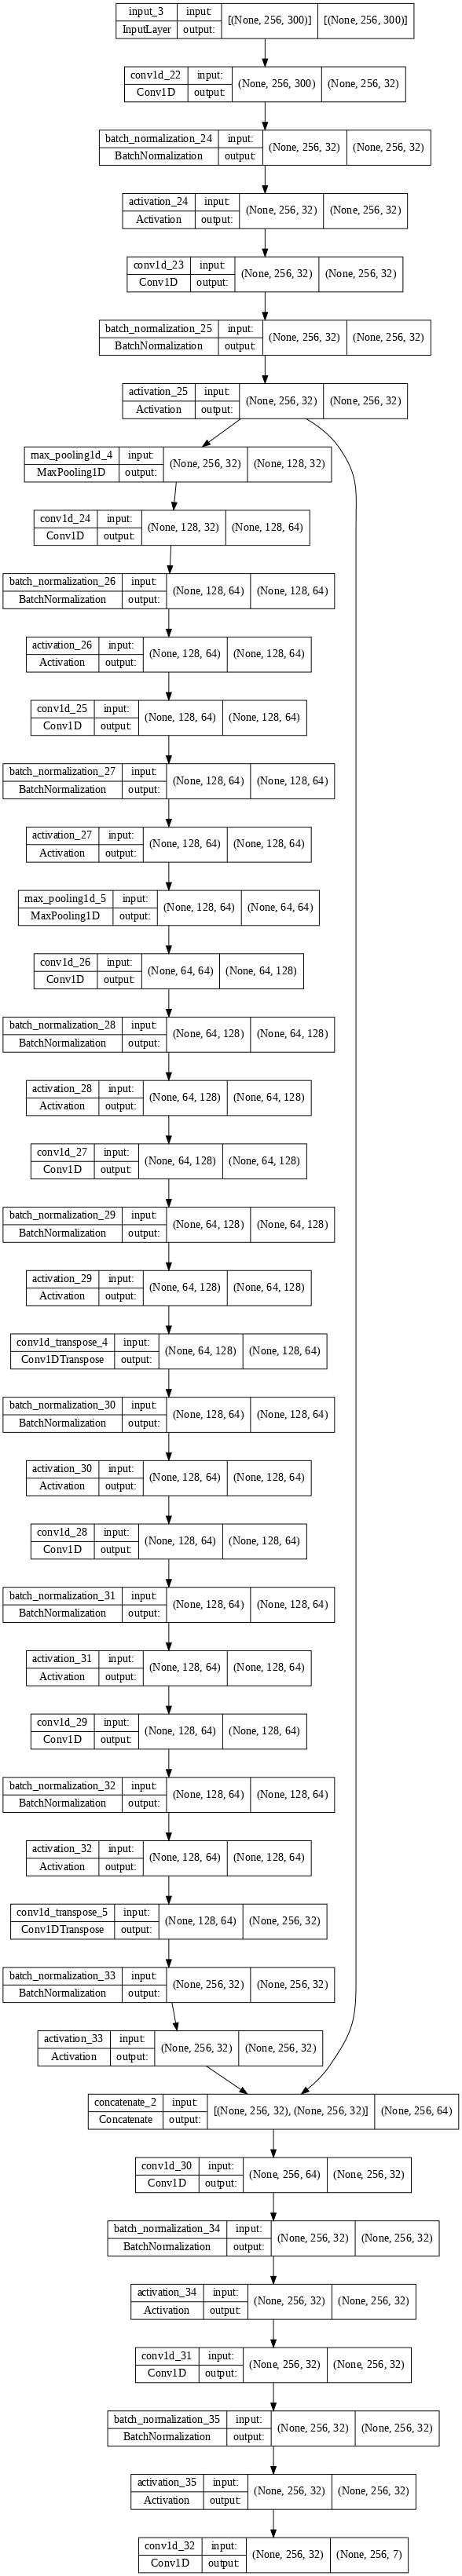

In [ ]:
plot_model(model, dpi=70, show_shapes=True) 

### **Обучение**

In [ ]:
history = model.fit(GENSIMtrainX, GENSIMtrainY, validation_data = (GENSIMtestX, GENSIMtestY), epochs=50, batch_size=64)

Epoch 1/50
214/214 [==============================] - 94s 416ms/step - loss: 3.5233 - dice_coef: 0.3438 - val_loss: 2.9824 - val_dice_coef: 0.3423
Epoch 2/50
214/214 [==============================] - 97s 455ms/step - loss: 3.5194 - dice_coef: 0.3441 - val_loss: 3.1528 - val_dice_coef: 0.3402
Epoch 3/50
214/214 [==============================] - 87s 406ms/step - loss: 3.5153 - dice_coef: 0.3443 - val_loss: 3.2171 - val_dice_coef: 0.3388
Epoch 4/50
214/214 [==============================] - 88s 413ms/step - loss: 3.5110 - dice_coef: 0.3446 - val_loss: 3.2231 - val_dice_coef: 0.3388
Epoch 5/50
214/214 [==============================] - 86s 403ms/step - loss: 3.5062 - dice_coef: 0.3449 - val_loss: 3.2198 - val_dice_coef: 0.3391
Epoch 6/50
214/214 [==============================] - 86s 401ms/step - loss: 3.5011 - dice_coef: 0.3453 - val_loss: 3.2154 - val_dice_coef: 0.3394
Epoch 7/50
214/214 [==============================] - 87s 404ms/step - loss: 3.4959 - dice_coef: 0.3456 - val_loss: 3.

### **Проверка результатов**

In [ ]:
recognizeSet(GENSIMtestX, GENSIMtestY, model, tags, xLen, 0.9) 

Сеть распознала категорию  'S1' с точностью в 69.74%
Сеть распознала категорию  'S2' с точностью в 97.91%
Сеть распознала категорию  'S3' с точностью в 87.37%
Сеть распознала категорию  'S4' с точностью в 85.07%
Сеть распознала категорию  'S5' с точностью в 93.49%
Сеть распознала категорию  'S6' с точностью в 99.8%
Средняя точность 77.57%


## Модель **PSPnet**

In [ ]:
def create_PSPNet(conv_size = 512, num_classes = 7, input_shape = (256, 300)):
    img_input = Input(input_shape)

    # Блок 1
    x = Conv1D(conv_size, 3, padding='same')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv1D(conv_size, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x_mp_2 = MaxPooling1D(2)(x)
    x_mp_4 = MaxPooling1D(4)(x)
    x_mp_8 = MaxPooling1D(8)(x)
    x_mp_16 = MaxPooling1D(16)(x)
    x_mp_32 = MaxPooling1D(32)(x)

    x_mp_2 = Conv1D(conv_size, 3, padding='same', activation='relu')(x_mp_2)
    x_mp_2 = Dropout(0.5)(x_mp_2)

    x_mp_4 = Conv1D(conv_size, 3, padding='same', activation='relu')(x_mp_4)
    x_mp_4 = Dropout(0.5)(x_mp_4)

    x_mp_8 = Conv1D(conv_size, 3, padding='same', activation='relu')(x_mp_8)
    x_mp_8 = Dropout(0.5)(x_mp_8)

    x_mp_16 = Conv1D(conv_size, 3, padding='same', activation='relu')(x_mp_16)
    x_mp_16 = Dropout(0.5)(x_mp_16)

    x_mp_32 = Conv1D(conv_size, 3, padding='same', activation='relu')(x_mp_32)
    x_mp_32 = Dropout(0.5)(x_mp_32) 

    x_mp_2 = Conv1DTranspose(conv_size, 2, strides=2)(x_mp_2)
    x_mp_2 = Activation('relu')(x_mp_2)

    x_mp_4 = Conv1DTranspose(conv_size, 4, strides=4)(x_mp_4)
    x_mp_4 = Activation('relu')(x_mp_4)

    x_mp_8 = Conv1DTranspose(conv_size, 8, strides=8)(x_mp_8)
    x_mp_8 = Activation('relu')(x_mp_8)

    x_mp_16 = Conv1DTranspose(conv_size, 16, strides=16)(x_mp_16)
    x_mp_16 = Activation('relu')(x_mp_16)

    x_mp_32 = Conv1DTranspose(conv_size, 32, strides=32)(x_mp_32)
    x_mp_32 = Activation('relu')(x_mp_32)

    fin = concatenate([img_input, x_mp_2, x_mp_4, x_mp_8, x_mp_16, x_mp_32])    
    fin = Conv1D(conv_size, 3, padding='same')(fin)
    fin = BatchNormalization()(fin)
    fin = Activation('relu')(fin)
    fin = Conv1D(conv_size, 3, padding='same')(fin)
    fin = BatchNormalization()(fin)
    fin = Activation('relu')(fin)

    fin = Conv1D(num_classes, 3, activation='sigmoid', padding='same')(fin)

    model = Model(img_input, fin)
    model.compile(optimizer=Adadelta(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    
    return model

In [ ]:
model_PSPnet = create_PSPNet()

In [ ]:
history_PSPnet = model_PSPnet.fit(GENSIMtrainX, GENSIMtrainY, validation_data = (GENSIMtestX, GENSIMtestY), epochs=30, batch_size=64)

Epoch 1/30
214/214 [==============================] - 106s 408ms/step - loss: 4.1173 - dice_coef: 0.3078 - val_loss: 3.4893 - val_dice_coef: 0.3108
Epoch 2/30
214/214 [==============================] - 88s 410ms/step - loss: 3.5987 - dice_coef: 0.3464 - val_loss: 3.1708 - val_dice_coef: 0.3482
Epoch 3/30
214/214 [==============================] - 88s 412ms/step - loss: 3.1616 - dice_coef: 0.3868 - val_loss: 2.8444 - val_dice_coef: 0.3852
Epoch 4/30
214/214 [==============================] - 88s 412ms/step - loss: 2.8167 - dice_coef: 0.4251 - val_loss: 2.5772 - val_dice_coef: 0.4195
Epoch 5/30
214/214 [==============================] - 88s 413ms/step - loss: 2.5620 - dice_coef: 0.4581 - val_loss: 2.3656 - val_dice_coef: 0.4498
Epoch 6/30
214/214 [==============================] - 88s 413ms/step - loss: 2.3819 - dice_coef: 0.4838 - val_loss: 2.2082 - val_dice_coef: 0.4737
Epoch 7/30
214/214 [==============================] - 88s 413ms/step - loss: 2.2602 - dice_coef: 0.5019 - val_loss: 2

### **Проверка результатов**

In [ ]:
recognizeSet(GENSIMtestX, GENSIMtestY, model_PSPnet, tags, xLen, 0.9) 

Сеть распознала категорию  'S1' с точностью в 55.1%
Сеть распознала категорию  'S2' с точностью в 88.75%
Сеть распознала категорию  'S3' с точностью в 65.04%
Сеть распознала категорию  'S4' с точностью в 68.56%
Сеть распознала категорию  'S5' с точностью в 71.56%
Сеть распознала категорию  'S6' с точностью в 97.08%
Средняя точность 75.59%


# Вариант 3

In [ ]:
xLen = 256
embeddingSize = 300 # Пространство Embedding

In [ ]:
kernel_size = 2          # Ядро
filters = 16    # Число фильтров

      
input = Input((256,300))  

x = Conv1D(filters, kernel_size, padding='same')(input)    
x = BatchNormalization()(x)                 
x = Activation('relu')(x)                   

x = Conv1D(filters, kernel_size, padding='same')(x)        
x = BatchNormalization()(x)                
block_1_out = Activation('relu')(x)         

x = MaxPooling1D()(block_1_out)            

x = Conv1D(filters*2, kernel_size, padding='same')(x) 
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv1D(filters*2, kernel_size, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = MaxPooling1D()(x)

x = Conv1D(filters*4, kernel_size, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv1D(filters*4, kernel_size, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# UP 

x = Conv1DTranspose(filters*2, kernel_size, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv1D(filters*2, kernel_size, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv1D(filters*2, kernel_size, padding='same')(x)   
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv1DTranspose(filters, 2, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = concatenate([x, block_1_out])

x = Conv1D(filters, kernel_size, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Conv1D(filters, kernel_size, padding='same')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# Выходной

x = Conv1D(7, kernel_size, activation = 'softmax', padding='same')(x)  # softmax

model = Model(input, x)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=[dice_coef])

In [ ]:
history = model.fit(GENSIMtrainX, GENSIMtrainY, validation_data = (GENSIMtestX, GENSIMtestY), epochs=30, batch_size=64)

Epoch 1/30
214/214 [==============================] - 26s 38ms/step - loss: 3.1068 - dice_coef: 0.2217 - val_loss: 2.7491 - val_dice_coef: 0.2280
Epoch 2/30
214/214 [==============================] - 6s 27ms/step - loss: 2.6455 - dice_coef: 0.2886 - val_loss: 2.3973 - val_dice_coef: 0.3108
Epoch 3/30
214/214 [==============================] - 6s 27ms/step - loss: 2.3912 - dice_coef: 0.3467 - val_loss: 2.1812 - val_dice_coef: 0.3758
Epoch 4/30
214/214 [==============================] - 6s 27ms/step - loss: 2.2365 - dice_coef: 0.3926 - val_loss: 2.0771 - val_dice_coef: 0.4164
Epoch 5/30
214/214 [==============================] - 6s 27ms/step - loss: 2.1574 - dice_coef: 0.4222 - val_loss: 2.0370 - val_dice_coef: 0.4344
Epoch 6/30
214/214 [==============================] - 6s 27ms/step - loss: 2.1196 - dice_coef: 0.4399 - val_loss: 2.0225 - val_dice_coef: 0.4454
Epoch 7/30
214/214 [==============================] - 6s 27ms/step - loss: 2.1080 - dice_coef: 0.4502 - val_loss: 2.0211 - val_di

In [ ]:
recognizeSet(GENSIMtestX, GENSIMtestY, model, tags, xLen, 0.9)

Сеть распознала категорию  'S1' с точностью в 69.74%
Сеть распознала категорию  'S2' с точностью в 97.98%
Сеть распознала категорию  'S3' с точностью в 87.48%
Сеть распознала категорию  'S4' с точностью в 86.26%
Сеть распознала категорию  'S5' с точностью в 93.68%
Сеть распознала категорию  'S6' с точностью в 99.91%
Средняя точность 77.46%


# Вариант 4

## Проверка работы сети 

In [ ]:
tags = ['S1', 'S2', 'S3', 'S4', 'S5', 'S6']

def recognizeSet(XX, YY, model, tags, length, value):
  correct_list = np.array([0] * 6) #Инициализируем массив правильных ответов в нули (сколько раз правильно определили класс)
  incorrect_list =  np.array([0] * 6)  #Инициализируем массив неправильных ответов в нули  (сколько раз неправильно определили класс)
  XX_array = XX
  YY_array = YY
  pred = model.predict(XX_array)
  pred[pred < value] = 0
  pred[pred > value] = 1

  for element in range(YY_array.shape[0]): # Проходим по всем примерам в батче
    for word in range(YY_array.shape[1]):  # Проходим по каждому слову
      for category in range(YY_array.shape[2]): # Проходим по каждой категории в слове
        if pred[element][word][category] == YY_array[element][word][category]: # Если предсказанное значение совпадает с истинным:
          correct_list[category] += 1 # Отмечаем, что мы правильно предсказали класс объекта
        else:  # Если предсказанное значение НЕ совпадает с истенным:
          incorrect_list[category] += 1 # Отмечаем, что мы не правильно предсказали класс объекта
      
  # Итоговая точность для каждого класса = кол. 100% * правильных/(кол. неправильных + кол. правильных)
  total = round(100*np.mean(correct_list/(correct_list + incorrect_list)),2) 
  return total

In [ ]:
GENSIMtrainX = np.load('/content/drive/MyDrive/УИИ/Cегментация текста/GENSIMtrainX.npy')
GENSIMtrainY = np.load('/content/drive/MyDrive/УИИ/Cегментация текста/GENSIMtrainY.npy')

GENSIMtestX = np.load('/content/drive/MyDrive/УИИ/Cегментация текста/GENSIMtestX.npy')
GENSIMtestY = np.load('/content/drive/MyDrive/УИИ/Cегментация текста/GENSIMtestY.npy')


In [ ]:
xLen = 256
embeddingSize = 300

In [ ]:
df = pd.DataFrame(columns = ['optimizer', 'avtivation_out', 'kernel_size', 'filters', 'Средняя точность'])
num = 1   # Счетчик экспериментов для записи в таблицу

In [ ]:
curr_time = time()

for optim in [Adadelta, Adam]:          # Оптимайзер
  for activ in ['sigmoid', 'softmax']:  # Активационная функция в выходном слое
    for kernel_size in [2, 3]:          # Ядро
      for filters in [4, 8, 16, 32]:    # Число фильтров

        fit_time = time()

        input = Input((256,300))  

        x = Conv1D(filters, kernel_size, padding='same')(input)    
        x = BatchNormalization()(x)                 
        x = Activation('relu')(x)                   

        x = Conv1D(filters, kernel_size, padding='same')(x)        
        x = BatchNormalization()(x)                
        block_1_out = Activation('relu')(x)         

        x = MaxPooling1D()(block_1_out)            

        x = Conv1D(filters*2, kernel_size, padding='same')(x) 
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv1D(filters*2, kernel_size, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = MaxPooling1D()(x)

        x = Conv1D(filters*4, kernel_size, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv1D(filters*4, kernel_size, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        # UP 

        x = Conv1DTranspose(filters*2, kernel_size, strides=2, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv1D(filters*2, kernel_size, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv1D(filters*2, kernel_size, padding='same')(x)   
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv1DTranspose(filters, 2, strides=2, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = concatenate([x, block_1_out])

        x = Conv1D(filters, kernel_size, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        x = Conv1D(filters, kernel_size, padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        # Выходной

        x = Conv1D(6, kernel_size, activation = activ, padding='same')(x)  # softmax
        
        model = Model(input, x)

        model.compile(optimizer=optim(learning_rate=0.0001), loss='categorical_crossentropy', metrics=[dice_coef])

        # Обучение
        history = model.fit(GENSIMtrainX, GENSIMtrainY, validation_data = (GENSIMtestX, GENSIMtestY), epochs=5, batch_size=64, verbose=0)

        # Проверка результата
        res = recognizeSet(GENSIMtestX, GENSIMtestY, model, tags, xLen, 0.8) 

        # Запись в таблицу
        if optim == Adadelta:
          df.loc[num] = ['Adadelta', activ, kernel_size, filters, res]
        else:
          df.loc[num] = ['Adam', activ, kernel_size, filters, res]

        df.to_csv('/content/drive/MyDrive/УИИ/Cегментация текста/df.csv')

        print(f"Время обучения {num} сети : {round(time() - fit_time, 2)} секунд")
        num += 1

print(f"Общее время составило: {round((time() - curr_time) / 60, 2)} минут")

Время обучения 1 сети : 24.06 секунды
Время обучения 2 сети : 16.77 секунды
Время обучения 3 сети : 15.07 секунды
Время обучения 4 сети : 15.66 секунды
Время обучения 5 сети : 16.84 секунды
Время обучения 6 сети : 12.84 секунды
Время обучения 7 сети : 14.03 секунды
Время обучения 8 сети : 15.34 секунды
Время обучения 9 сети : 11.66 секунды
Время обучения 10 сети : 12.49 секунды
Время обучения 11 сети : 11.67 секунды
Время обучения 12 сети : 16.68 секунды
Время обучения 13 сети : 11.65 секунды
Время обучения 14 сети : 12.41 секунды
Время обучения 15 сети : 12.73 секунды
Время обучения 16 сети : 12.07 секунды
Время обучения 17 сети : 16.11 секунды
Время обучения 18 сети : 12.54 секунды
Время обучения 19 сети : 12.26 секунды
Время обучения 20 сети : 12.27 секунды
Время обучения 21 сети : 12.0 секунды
Время обучения 22 сети : 16.1 секунды
Время обучения 23 сети : 16.82 секунды
Время обучения 24 сети : 12.02 секунды
Время обучения 25 сети : 12.26 секунды
Время обучения 26 сети : 12.04 секун

In [ ]:
df.to_csv('/content/drive/MyDrive/УИИ/Cегментация текста/df.csv')

In [ ]:
df

,optimizer,avtivation_out,kernel_size,filters,Средняя точность
1,Adadelta,sigmoid,2,4,88.97
2,Adadelta,sigmoid,2,8,89.15
3,Adadelta,sigmoid,2,16,88.96
4,Adadelta,sigmoid,2,32,88.60
5,Adadelta,sigmoid,3,4,88.53
6,Adadelta,sigmoid,3,8,89.09
7,Adadelta,sigmoid,3,16,88.19
8,Adadelta,sigmoid,3,32,88.10
9,Adadelta,softmax,2,4,89.17
10,Adadelta,softmax,2,8,89.17


Данная таблица доступна по ссылке: https://drive.google.com/file/d/1--e3QZ3efm9ssN7b-9_UFhwfE4epSAE6/view?usp=sharing

# Выводы:

1. Для достижения результата требловалось провести большое количество разных экспериментов.
2. Были опробованы разные архитектуры и гиперпараметры.
3. Для автоматизации процесса были использованы циклы. А результаты автоматически записывались в таблицу.
4. Данная домашняя работа показывает как имея ограченный набор обучающих данных можно добиться лучшего результата подбирая различные архитектуры.
5. Выполняя задание можно получить хороший навык работы и понимания как меняются размерности в различных слоях.